In [5]:
import pandas as pd
import numpy as np
import requests
from functools import reduce
from io import StringIO
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from pygam import LogisticGAM, s, f
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion
import matplotlib.pyplot as plt
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show

In [6]:
train_url = "https://files.challengerocket.com/files/lions-den-ing-2024/development_sample.csv"
test_url = "https://files.challengerocket.com/files/lions-den-ing-2024/testing_sample.csv"


def load_data(url):
    response = requests.get(url)
    if response.status_code == 200:
        csv_data = response.text
        csv_file = StringIO(csv_data)
        return pd.read_csv(csv_file)
    else:
        print("Nie udało się pobrać danych.")


train = load_data(train_url)
test = load_data(test_url)

train.dropna(subset=['target'], inplace=True)
test.dropna(subset=['target'], inplace=True)

train_id = train["ID"]
test_id = test["ID"]

data = [train, test]
columns_to_drop = ["ID", "customer_id", "application_date", "Application_status", "Var13"]

for frame in data:
    frame.drop(columns=columns_to_drop, inplace=True)

print("Dane treningowe:")
print(train.head())

y_train = train["target"]
y_test = test["target"]

print(y_train)
print(y_train.shape)
print(train.shape)

for frame in data:
    frame.drop(columns=["target"], inplace=True)

print("Dane treningowe:")
print(train.head())
print("\nDane testowe:")
print(test.head())

categorical_features = []
numerical_features = []

for column in train.columns:
    if train[column].dtype == 'object':
        categorical_features.append(column)
    else:
        numerical_features.append(column)

print("categorical: ", categorical_features)
print("numerical: ", numerical_features)


class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.attribute_names]


num_pipeline = Pipeline([
    ("selector", DataFrameSelector(numerical_features)),
    ("imputer", SimpleImputer(strategy='mean')),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("selector", DataFrameSelector(categorical_features)),
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ("encoder", OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline)
])

X_train_transformed = full_pipeline.fit_transform(train)
X_test_transformed = full_pipeline.transform(test)

transformed_cat_columns = full_pipeline.transformer_list[1][1]['encoder'].get_feature_names_out(categorical_features)

transformed_column_names = numerical_features + list(transformed_cat_columns)

X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=transformed_column_names)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=transformed_column_names)

print("Transformed Train Data:")
print(X_train_transformed_df.head())

print("Transformed Test Data:")
print(X_test_transformed_df.head())

print(X_train_transformed_df.columns)

X = X_train_transformed_df
y = y_train

print(X.shape)
print(y.shape)

Dane treningowe:
   target  Var1  Var2 Var3   Var4  Var5  Var6     Var7     Var8  Var9  ...  \
0     0.0     1   2.0    1   7800    99     1   108.73      NaN  5640  ...   
1     0.0     1   1.0    2  11100    78     1   195.99  11200.0  3000  ...   
2     0.0     2   3.0    1   2400    15     1   248.34      NaN  6240  ...   
3     0.0     3   1.0    2  11800    30     6  3538.68  12400.0  4560  ...   
5     0.0     1   2.0    1   7200    36     1   267.19      NaN  3960  ...   

   Var22  Var23  Var24    Var25     Var26  Var27  Var28  Var29  Var30  \
0      1      1      0  6768.42      0.00      0      0      0   3899   
1      0      0  15000  5937.66   3870.60      0      0      0   3899   
2      2      2      0  5647.77   1463.08      0      0     10   3899   
3      0      0      0  3594.90  21563.78      0      0     10   3899   
5      2      2      0  1828.62       NaN      0      0     10   3899   

        _r_  
0  0.267045  
1  0.533040  
2  0.861555  
3  0.506451  
5  0.

In [7]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic')
xgb_model.fit(X, y)

# Predict probabilities and labels for the train set
y_pred_proba_train_xgb = xgb_model.predict_proba(X)[:, 1]
y_pred_train_xgb = np.array([1 if p > 0.97 else 0 for p in y_pred_proba_train_xgb])

# Calculate AUC for the train set
auc_train_xgb = roc_auc_score(y, y_pred_proba_train_xgb)
print("AUC on Train Data:", auc_train_xgb)

# Calculate accuracy, precision, recall, and F1-score for the train set
accuracy_train_xgb = accuracy_score(y, y_pred_train_xgb)
precision_train_xgb = precision_score(y, y_pred_train_xgb)
recall_train_xgb = recall_score(y, y_pred_train_xgb)
f1_train_xgb = f1_score(y, y_pred_train_xgb)
print("Accuracy on Train Data:", accuracy_train_xgb)
print("Precision on Train Data:", precision_train_xgb)
print("Recall on Train Data:", recall_train_xgb)
print("F1-score on Train Data:", f1_train_xgb)

# Predict probabilities and labels for the test set
y_pred_proba_test_xgb = xgb_model.predict_proba(X_test_transformed_df)[:, 1]
y_pred_test_xgb = np.array([1 if p > 0.90 else 0 for p in y_pred_proba_test_xgb])

# Calculate AUC for the test set
auc_test_xgb = roc_auc_score(y_test, y_pred_proba_test_xgb)
print("AUC on Test Data:", auc_test_xgb)

# Calculate accuracy, precision, recall, and F1-score for the test set
accuracy_test_xgb = accuracy_score(y_test, y_pred_test_xgb)
precision_test_xgb = precision_score(y_test, y_pred_test_xgb)
recall_test_xgb = recall_score(y_test, y_pred_test_xgb)
f1_test_xgb = f1_score(y_test, y_pred_test_xgb)
print("Accuracy on Test Data:", accuracy_test_xgb)
print("Precision on Test Data:", precision_test_xgb)
print("Recall on Test Data:", recall_test_xgb)
print("F1-score on Test Data:", f1_test_xgb)

AUC on Train Data: 0.9943402139714244
Accuracy on Train Data: 0.9709406830437388
Precision on Train Data: 1.0
Recall on Train Data: 0.05323868677905945
F1-score on Train Data: 0.10109519797809603
AUC on Test Data: 0.7303689709970327
Accuracy on Test Data: 0.9665478475459282
Precision on Test Data: 0.0
Recall on Test Data: 0.0
F1-score on Test Data: 0.0


In [44]:
ebm = ExplainableBoostingClassifier()
ebm.fit(X, y)

# Predict probabilities and labels for the train set
y_pred_proba_train_ebm = ebm.predict_proba(X)[:, 1]
y_pred_train_ebm = np.array([1 if p > 0.59 else 0 for p in y_pred_proba_train_ebm])

# Calculate AUC for the train set
auc_train_ebm = roc_auc_score(y, y_pred_proba_train_ebm)
print("AUC on Train Data:", auc_train_ebm)

# Calculate accuracy, precision, recall, and F1-score for the train set
accuracy_train_ebm = accuracy_score(y, y_pred_train_ebm)
precision_train_ebm = precision_score(y, y_pred_train_ebm)
recall_train_ebm = recall_score(y, y_pred_train_ebm)
f1_train_ebm = f1_score(y, y_pred_train_ebm)
print("Accuracy on Train Data:", accuracy_train_ebm)
print("Precision on Train Data:", precision_train_ebm)
print("Recall on Train Data:", recall_train_ebm)
print("F1-score on Train Data:", f1_train_ebm)

# Predict probabilities and labels for the test set
y_pred_proba_test_ebm = ebm.predict_proba(X_test_transformed_df)[:, 1]
print(y_pred_proba_test_ebm)
y_pred_test_ebm = np.array([1 if p > 0.59 else 0 for p in y_pred_proba_test_ebm])
print(y_pred_test_ebm)

# Calculate AUC for the test set
auc_test_ebm = roc_auc_score(y_test, y_pred_proba_test_ebm)
print("AUC on Test Data:", auc_test_ebm)

# Calculate accuracy, precision, recall, and F1-score for the test set
accuracy_test_ebm = accuracy_score(y_test, y_pred_test_ebm)
precision_test_ebm = precision_score(y_test, y_pred_test_ebm)
recall_test_ebm = recall_score(y_test, y_pred_test_ebm)
f1_test_ebm = f1_score(y_test, y_pred_test_ebm)
print("Accuracy on Test Data:", accuracy_test_ebm)
print("Precision on Test Data:", precision_test_ebm)
print("Recall on Test Data:", recall_test_ebm)
print("F1-score on Test Data:", f1_test_ebm)

AUC on Train Data: 0.880426337306444
Accuracy on Train Data: 0.9724113513807942
Precision on Train Data: 0.9253731343283582
Recall on Train Data: 0.11002661934338953
F1-score on Train Data: 0.19666931007137195
[0.11976983 0.01424147 0.01415852 ... 0.00145846 0.0024584  0.02266913]
[0 0 0 ... 0 0 0]
AUC on Test Data: 0.7902499964842046
Accuracy on Test Data: 0.9668220455168631
Precision on Test Data: 0.5
Recall on Test Data: 0.01652892561983471
F1-score on Test Data: 0.03200000000000001


In [36]:
def localsum(x):
    total=x[0]
    for i in range(1,len(x)):
        total+=x[i]
    return total
    
gam = LogisticGAM(localsum([s(i) for i in range(34)])).fit(X, y)
y_pred_proba_train_gam = gam.predict_proba(X)

# Calculate AUC for train set
auc_train_gam = roc_auc_score(y, y_pred_proba_train_gam)
print("AUC (Train):", auc_train_gam)

# Convert predicted probabilities to binary predictions for train set
y_pred_train_gam = np.array([1 if p > 0.9 else 0 for p in y_pred_proba_train_gam])

# Calculate accuracy for train set
accuracy_train_gam = accuracy_score(y, y_pred_train_gam)
print("Accuracy (Train):", accuracy_train_gam)

# Calculate precision, recall, and F1-score for train set
precision_train_gam = precision_score(y, y_pred_train_gam)
recall_train_gam = recall_score(y, y_pred_train_gam)
f1_train_gam = f1_score(y, y_pred_train_gam)
print("Precision (Train):", precision_train_gam)
print("Recall (Train):", recall_train_gam)
print("F1-score (Train):", f1_train_gam)

# Predict probabilities on the test set
y_pred_proba_test_gam = gam.predict_proba(X_test_transformed_df)

# Calculate AUC for test set
auc_test_gam = roc_auc_score(y_test, y_pred_proba_test_gam)
print("AUC (Test):", auc_test_gam)

# Convert predicted probabilities to binary predictions for test set
y_pred_test_gam = np.array([1 if p > 0.9 else 0 for p in y_pred_proba_test_gam])

# Calculate accuracy for test set
accuracy_test_gam = accuracy_score(y_test, y_pred_test_gam)
print("Accuracy (Test):", accuracy_test_gam)

# Calculate precision, recall, and F1-score for test set
precision_test_gam = precision_score(y_test, y_pred_test_gam)
recall_test_gam = recall_score(y_test, y_pred_test_gam)
f1_test_gam = f1_score(y_test, y_pred_test_gam)
print("Precision (Test):", precision_test_gam)
print("Recall (Test):", recall_test_gam)
print("F1-score (Test):", f1_test_gam)


AUC (Train): 0.8224110872969517
Accuracy (Train): 0.9703687564682172
Precision (Train): 0.975609756097561
Recall (Train): 0.0354924578527063
F1-score (Train): 0.06849315068493152
AUC (Test): 0.7762805698401016
Accuracy (Test): 0.9668220455168631
Precision (Test): 0.0
Recall (Test): 0.0
F1-score (Test): 0.0


C:\Users\karol\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


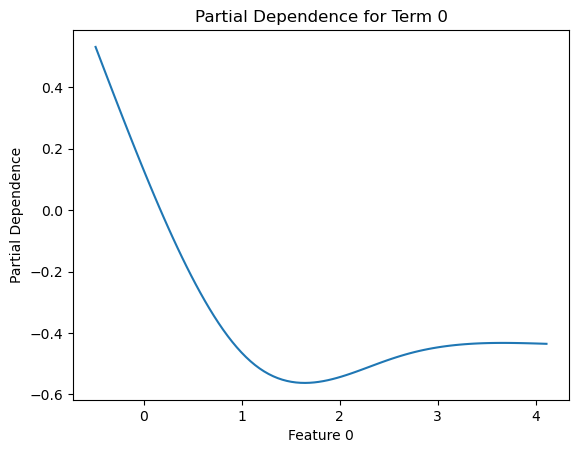

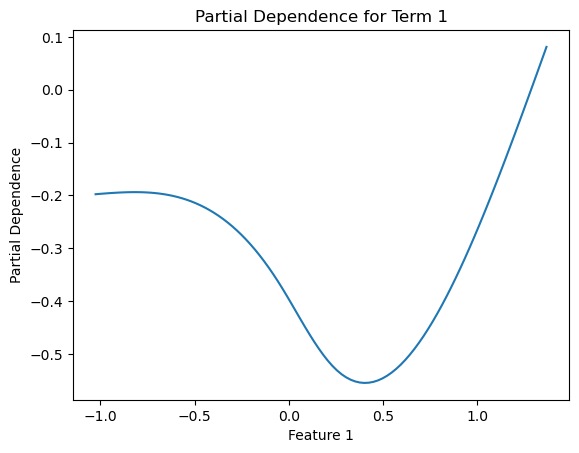

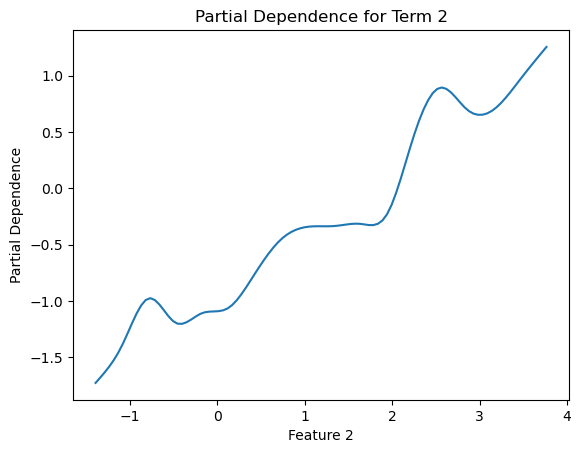

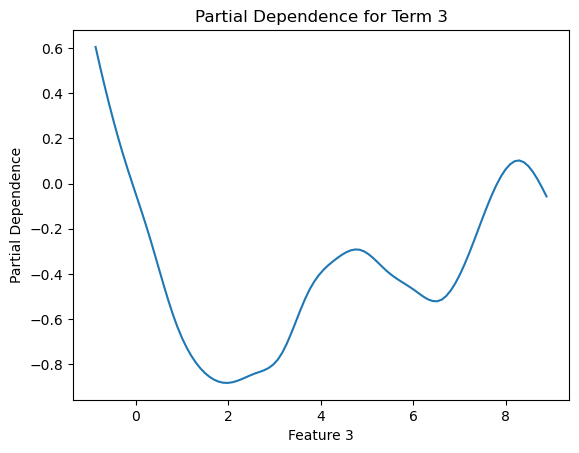

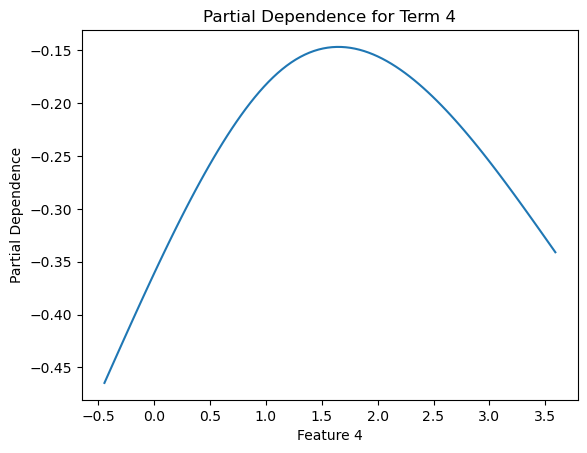

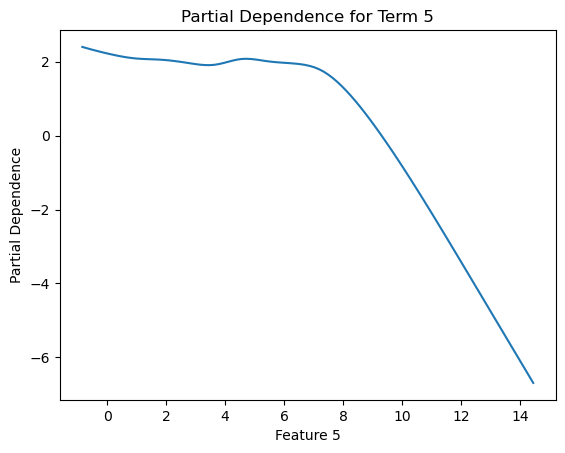

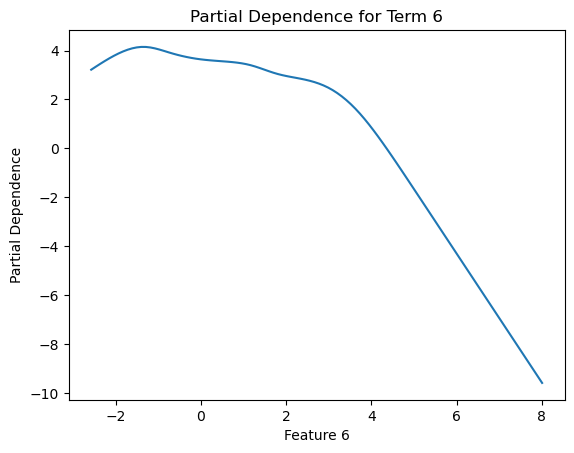

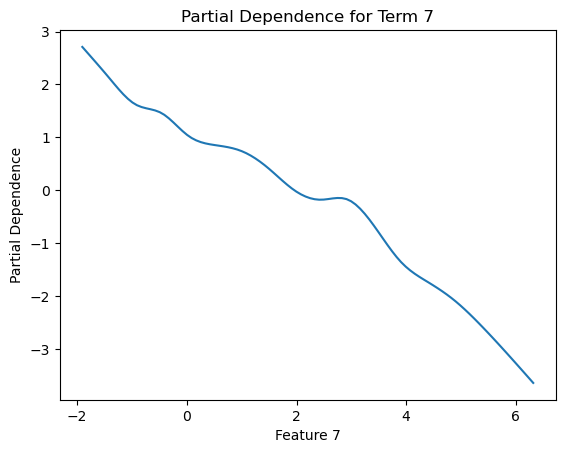

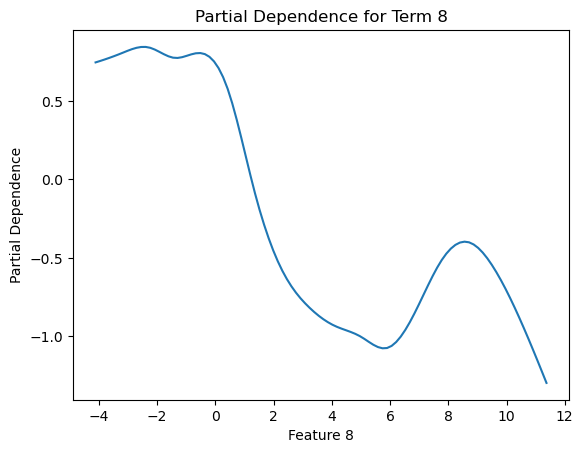

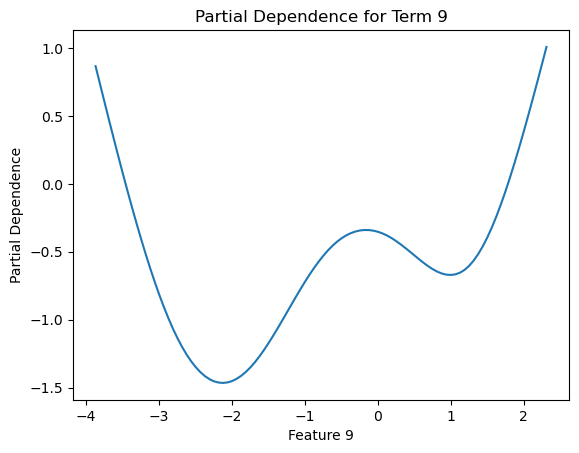

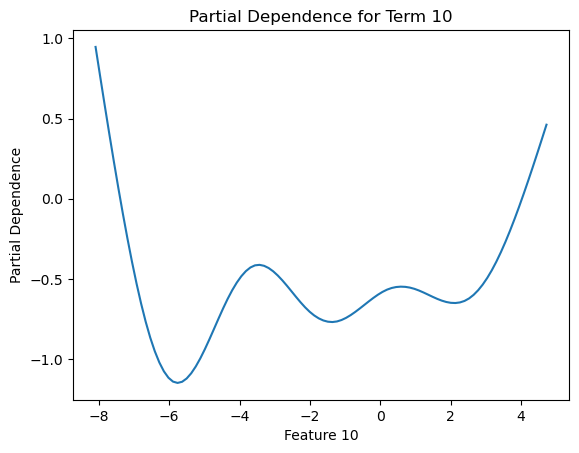

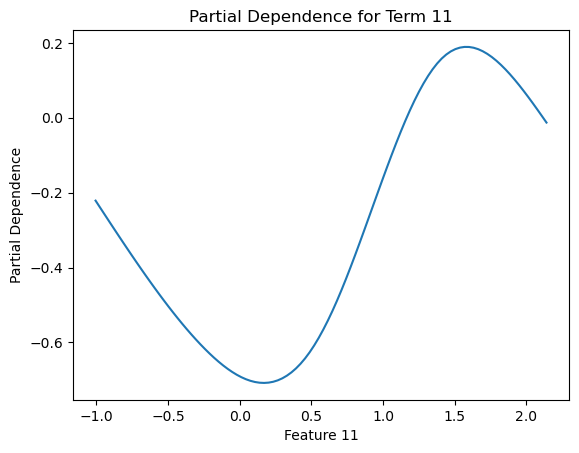

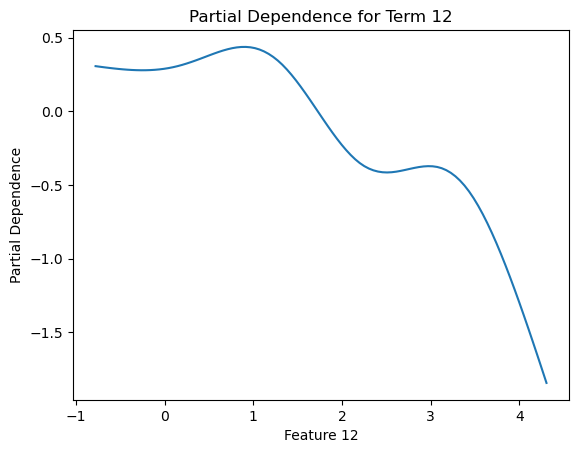

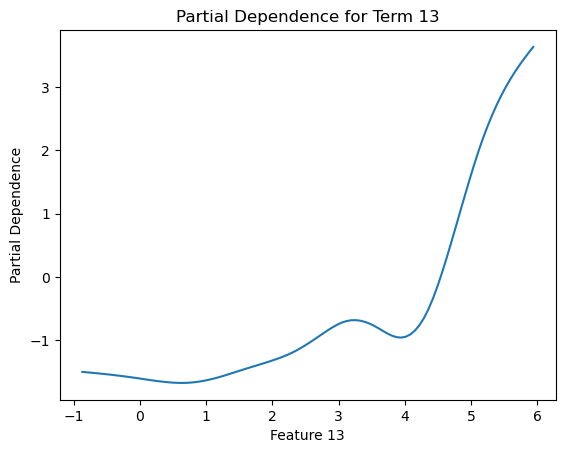

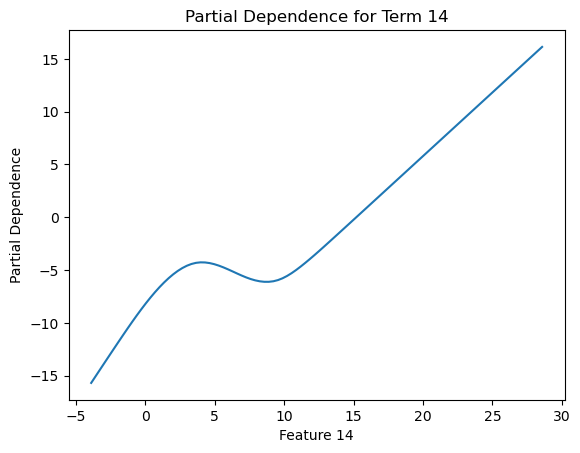

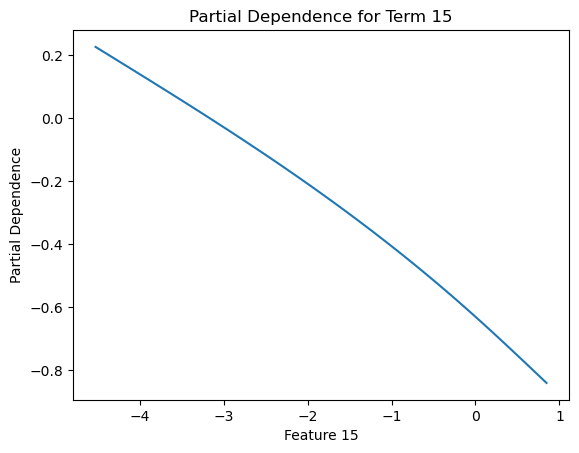

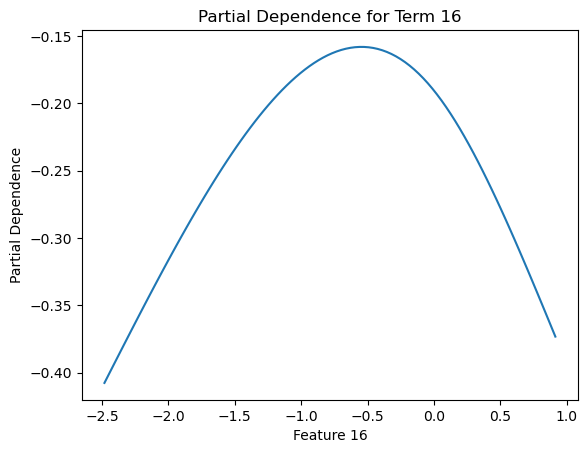

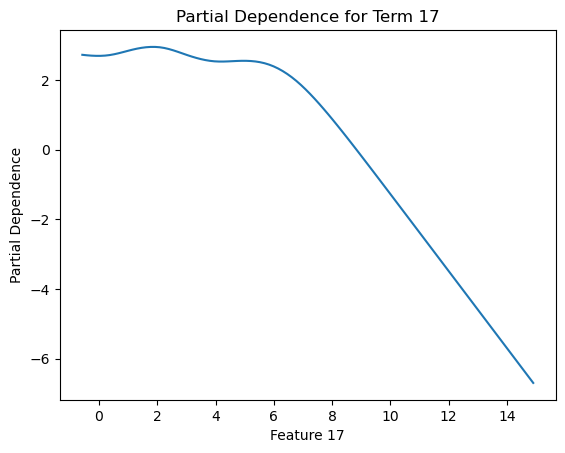

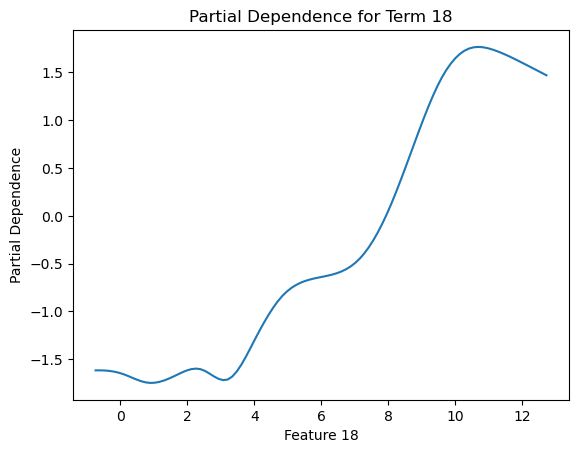

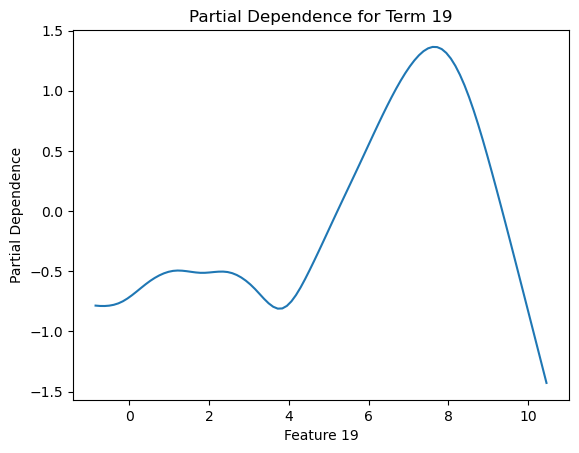

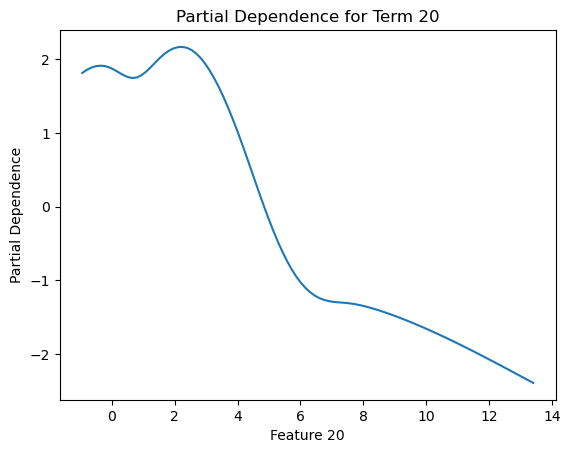

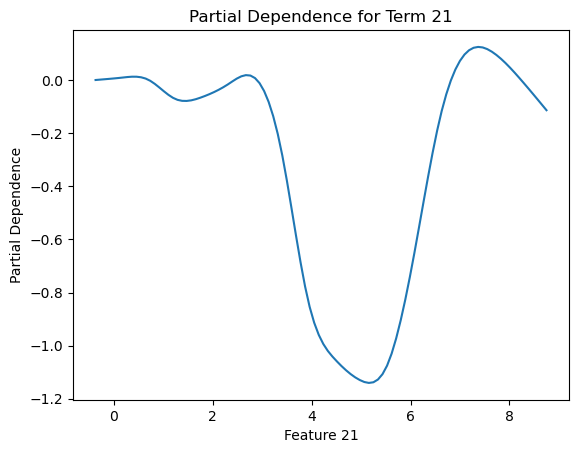

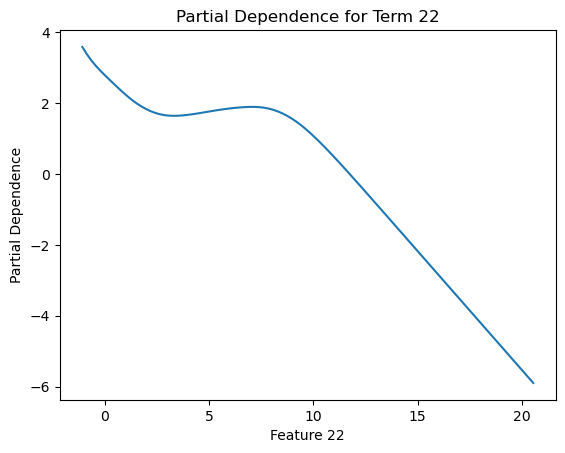

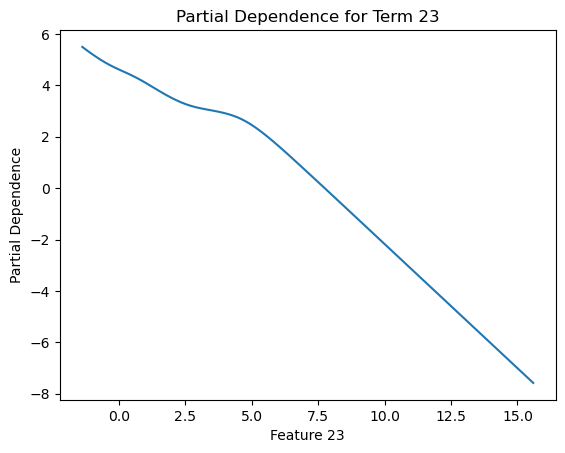

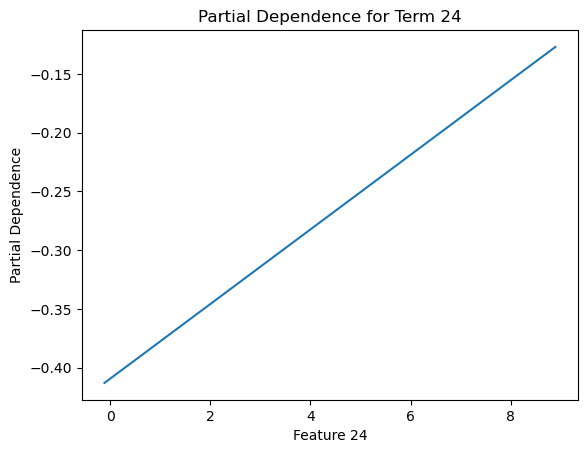

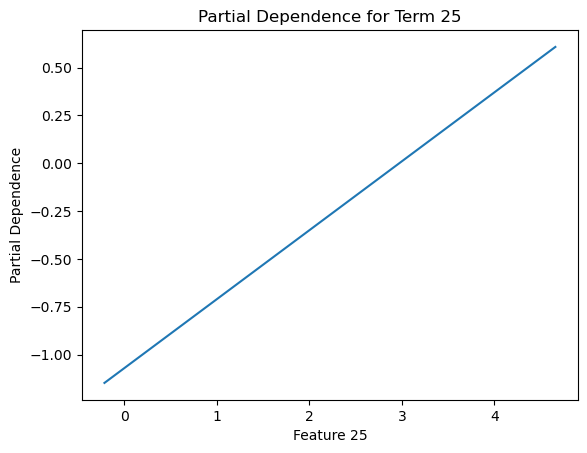

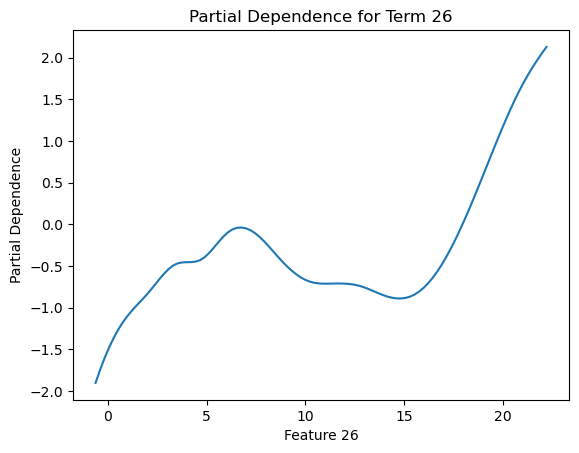

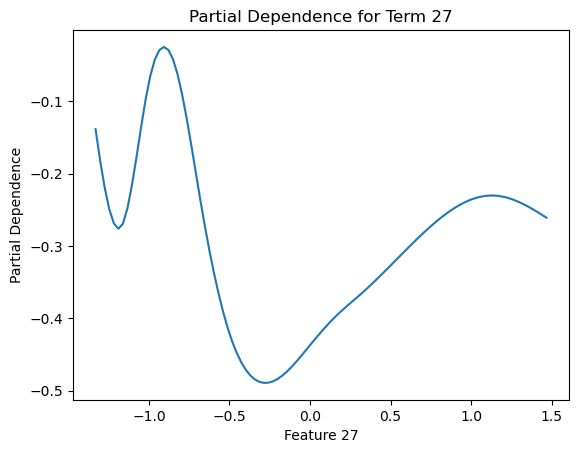

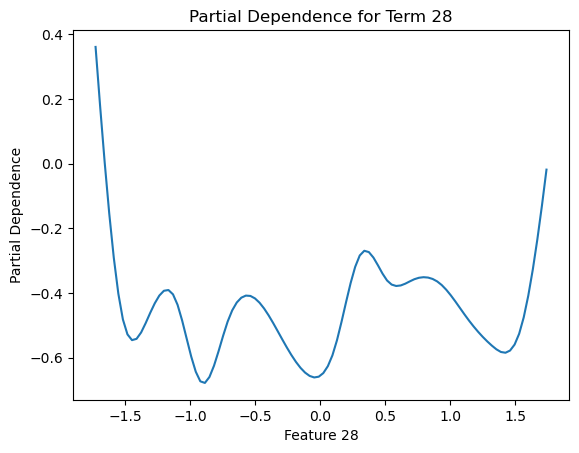

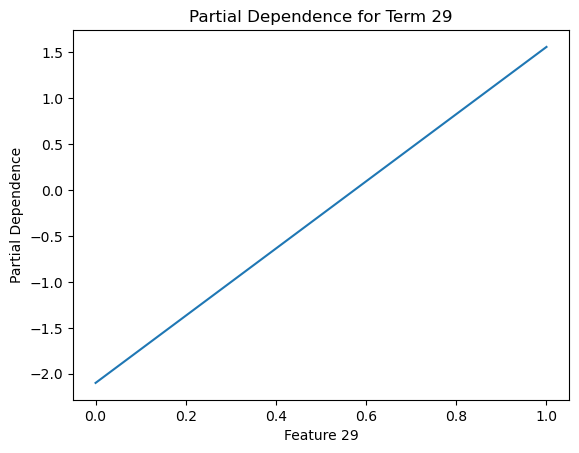

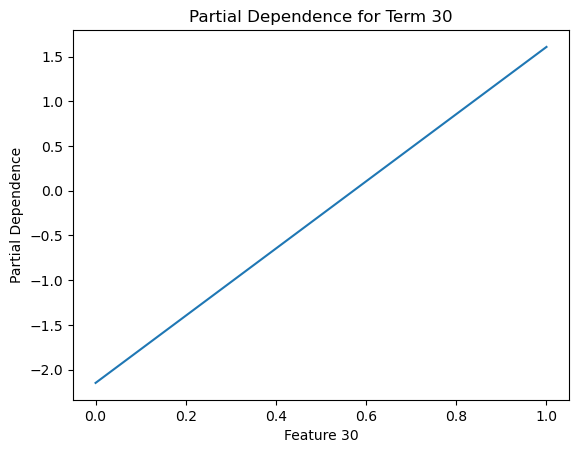

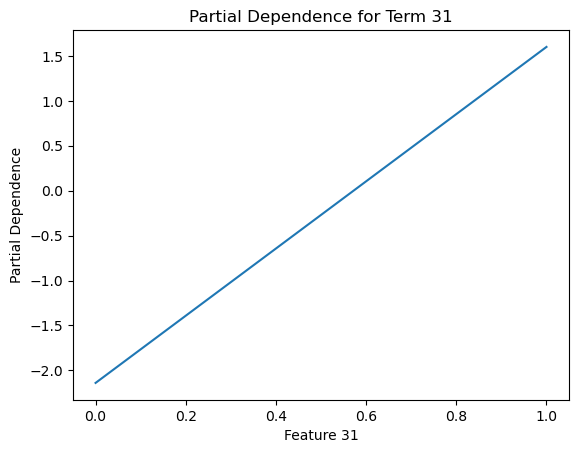

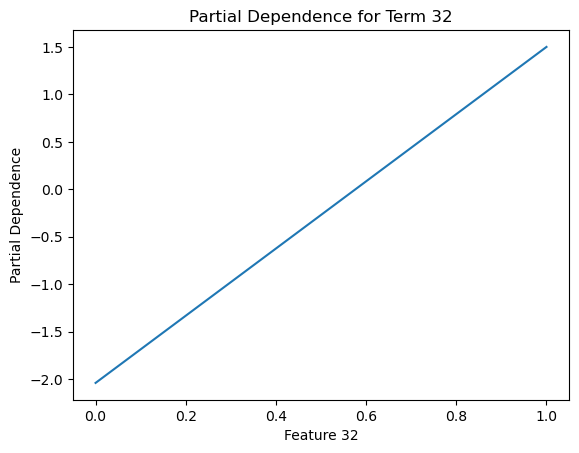

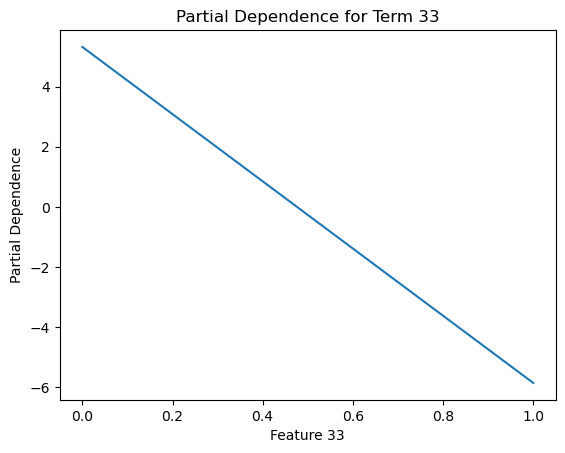

In [38]:
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=.95)

     #Plot partial dependence
    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.title(f'Partial Dependence for Term {i}')
    plt.xlabel(f'Feature {term.feature}')
    plt.ylabel('Partial Dependence')
    plt.show()

In [ ]:
def model_evaluation(model):
    ebm.fit(X, y)

    print(f"Evaluation for {} model:"
    # Predict probabilities and labels for the train set
    y_pred_proba_train_model = model.predict_proba(X)[:, 1]
    y_pred_train_model = np.array([1 if p > 0.9 else 0 for p in y_pred_proba_train_model])

    # Calculate AUC for the train set
    auc_train_model = roc_auc_score(y, y_pred_proba_train_model)
    print("AUC on Train Data:", auc_train_model)

    # Calculate accuracy, precision, recall, and F1-score for the train set
    accuracy_train_model = accuracy_score(y, y_pred_train_model)
    precision_train_ebm = precision_score(y, y_pred_train_model)
    recall_train_ebm = recall_score(y, y_pred_train_model)
    f1_train_ebm = f1_score(y, y_pred_train_model)
    print("Accuracy on Train Data:", accuracy_train_model)
    print("Precision on Train Data:", precision_train_model)
    print("Recall on Train Data:", recall_train_model)
    print("F1-score on Train Data:", f1_train_model)

    # Predict probabilities and labels for the test set
    y_pred_proba_test_ebm = ebm.predict_proba(X_test_transformed_df)[:, 1]
    print(y_pred_proba_test_ebm)
    y_pred_test_ebm = np.array([1 if p > 0.2 else 0 for p in y_pred_proba_test_ebm])
    print(y_pred_test_ebm)

    # Calculate AUC for the test set
    auc_test_ebm = roc_auc_score(y_test, y_pred_proba_test_ebm)
    print("AUC on Test Data:", auc_test_ebm)

    # Calculate accuracy, precision, recall, and F1-score for the test set
    accuracy_test_ebm = accuracy_score(y_test, y_pred_test_ebm)
    precision_test_ebm = precision_score(y_test, y_pred_test_ebm)
    recall_test_ebm = recall_score(y_test, y_pred_test_ebm)
    f1_test_ebm = f1_score(y_test, y_pred_test_ebm)
    print("Accuracy on Test Data:", accuracy_test_ebm)
    print("Precision on Test Data:", precision_test_ebm)
    print("Recall on Test Data:", recall_test_ebm)
    print("F1-score on Test Data:", f1_test_ebm)

In [34]:
def evaluate_model(model, X_train, y_train, X_test, y_test, threshold=0.51):
    model_name = type(model).__name__
    print(f"Evaluating model: {model_name}")
    
    # Train set
    y_pred_proba_train = model.predict_proba(X_train)[:, 1]
    auc_train = roc_auc_score(y_train, y_pred_proba_train)
    y_pred_train = np.array([1 if p > threshold else 0 for p in y_pred_proba_train])
    accuracy_train = accuracy_score(y_train, y_pred_train)
    precision_train = precision_score(y_train, y_pred_train)
    recall_train = recall_score(y_train, y_pred_train)
    f1_train = f1_score(y_train, y_pred_train)
    
    # Test set
    y_pred_proba_test = model.predict_proba(X_test)[:, 1]
    auc_test = roc_auc_score(y_test, y_pred_proba_test)
    y_pred_test = np.array([1 if p > threshold else 0 for p in y_pred_proba_test])
    accuracy_test = accuracy_score(y_test, y_pred_test)
    precision_test = precision_score(y_test, y_pred_test)
    recall_test = recall_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    
    # Create DataFrame
    data = {
        'Model': [model_name, model_name],
        'Dataset': ['Train', 'Test'],
        'AUC': [auc_train, auc_test],
        'Accuracy': [accuracy_train, accuracy_test],
        'Precision': [precision_train, precision_test],
        'Recall': [recall_train, recall_test],
        'F1-score': [f1_train, f1_test]
    }
    df = pd.DataFrame(data)
    
    return df

In [35]:
print(evaluate_model(xgb_model,X,y,X_test_transformed_df,y_test))

Evaluating model: XGBClassifier
           Model Dataset       AUC  Accuracy  Precision    Recall  F1-score
0  XGBClassifier   Train  0.994340  0.984994   1.000000  0.511091  0.676453
1  XGBClassifier    Test  0.730369  0.965725   0.333333  0.033058  0.060150


In [37]:
def find_best_threshold(y_true, y_proba):
    best_threshold = 0
    best_precision = 0
    
    for threshold in np.arange(0, 1, 0.01):
        y_pred = [1 if p > threshold else 0 for p in y_proba]
        precision = precision_score(y_true, y_pred)
        
        if precision > best_precision:
            best_precision = precision
            best_threshold = threshold
    
    return best_threshold, best_precision

In [43]:
print(find_best_threshold(y_test,y_pred_proba_test_ebm))

(0.59, 0.5)


C:\Users\karol\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\karol\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\karol\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\karol\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision 